# Cargamos y preprocesamos los datos

Particularmente en este caso, creo que la mejor opción frente a los registros con valores nulos es la de eliminarlos, esto debido a que están en características con valores categóricos y discretos, por lo que otros métodos como reemplazar estos registros con valores medios, o con algún valor numérico (como por ejemplo 0) tendría como resultado una posible inconsistencia en los datos.

In [276]:
import pandas as pd
import numpy as np

archivo = "Test práctica.xlsx"
df = pd.read_excel(archivo, sheet_name=0, engine='openpyxl')

# Primera visualización de los datos
display(df.info())
print(f'\nCatastro de valores nulos: \n{df.isna().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_retiro              4510 non-null   int64  
 1   fecha_retiro           4510 non-null   object 
 2   comuna                 4357 non-null   object 
 3   ruta                   4256 non-null   float64
 4   inicio_ventana_retiro  4510 non-null   object 
 5   fin_ventana_retiro     4510 non-null   object 
 6   fecha_hora_courier     4408 non-null   object 
 7   ultimo_evento_courier  4510 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 282.0+ KB


None


Catastro de valores nulos: 
id_retiro                  0
fecha_retiro               0
comuna                   153
ruta                     254
inicio_ventana_retiro      0
fin_ventana_retiro         0
fecha_hora_courier       102
ultimo_evento_courier      0
dtype: int64


In [277]:
df = df.dropna()

### Pregunta 1
Cuantos retiros tienen hora de retiro después de las 13:00?

Para esta pregunta, fue necesario formatear la columna 'fecha_hora_courier' para utilizar herramientas de pandas, en este caso, como nos interesa solamente la hora y no los minutos ni los segundos, y viendo que los datos están en formato 24hrs, utilizamos dt.hour para extraer la hora y con esto, seleccionamos los registros que tienen una hora de retiro posterior o igual a las 13:00 hrs

In [278]:
df['fecha_hora_courier'] = pd.to_datetime(df['fecha_hora_courier'])

retiros_horario_pm = df[df['fecha_hora_courier'].dt.hour >= 13]

print(f'Hay {len(retiros_horario_pm)} retiros de un total de {len(df)} que tienen hora de retiro después de las 13:00')

Hay 3403 retiros de un total de 4207 que tienen hora de retiro después de las 13:00


### Pregunta 2
Cuál es el % de retiro exitoso y de no retirado del total de casos?


En esta pregunta, nos bastó con realizar un groupby de la columna 'ultimo_evento_courier' pero con la precaución de que los datos existentes en esta columna tengan únicamente los valores ['Retiro Exitoso' y 'No Retirado'], una vez teniendo estos datos, podemos sacar la proporción del total, también realizamos un gráfico de torta simple para una mejor visualización de los datos

Existen 2 clases posibles, estas son: ['Retiro Exitoso' 'No Retirado']
La distribución de datos es la siguiente: 
ultimo_evento_courier
No Retirado        899
Retiro Exitoso    3308
dtype: int64
El % de registros que tuvieron un retiro exitoso del total es: 78.60000000000001%
El % de registros que tuvieron un retiro NO exitoso del total es: 21.4%


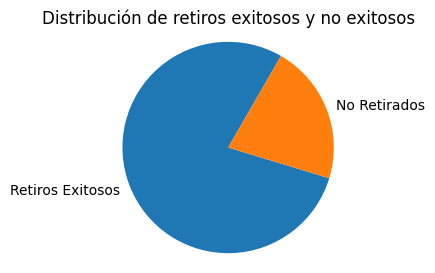

In [279]:
import matplotlib.pyplot as plt

# Primero aseguramos la integridad y consistencia de los datos
print(f"Existen {len(df['ultimo_evento_courier'].unique())} clases posibles, estas son: {df['ultimo_evento_courier'].unique()}")

conteo = df.groupby("ultimo_evento_courier").size()

print(f"La distribución de datos es la siguiente: \n{conteo}")

# Definimos las variables para un mejor entendimiento
retiros_e = conteo['Retiro Exitoso']
retiros_n = conteo['No Retirado']
total = conteo.sum()

# Mostramos los resultados
print(f"El % de registros que tuvieron un retiro exitoso del total es: {np.around(retiros_e/total, 3)*100}%")
print(f"El % de registros que tuvieron un retiro NO exitoso del total es: {np.around(retiros_n/total, 3)*100}%")

plt.figure(figsize=(3, 3))
plt.pie([(retiros_e/total)*100, (retiros_n/total)*100], labels=['Retiros Exitosos', 'No Retirados'], startangle=60)
plt.title('Distribución de retiros exitosos y no exitosos')
plt.axis('equal')

plt.show()


### Pregunta 3
Cuántas rutas hay por comuna?


Para realizar esta pregunta, nuevamente realizamos un groupby de las columna 'ruta' según las comunas existentes en la columna 'comuna', esta forma permite una mejor lectura y un menor coste computacional que otras opciones, además, ordenamos la información por la cantidad de rutas por comuna de forma descendente para ver cuales comunas tienen una mayor concentración de rutas, lo que nos podría indicar aquellas que tienen un desarrollo prioritario en términos de logística.

In [280]:
rutas_totales = df[df['ruta'].notna()].groupby("comuna").size().reset_index(name="cantidad_rutas")
display(rutas_totales.sort_values(by='cantidad_rutas', ascending=False).reset_index(drop=True))


,comuna,cantidad_rutas
0,PUDAHUEL,249
1,SANTIAGO,240
2,LAS CONDES,170
3,PROVIDENCIA,167
4,QUILICURA,164
...,...,...
277,RENAICO,1
278,QUIRIHUE,1
279,NEGRETE,1
280,QUINTA DE TILCOCO,1


### Pregunta 4
Cuántos retiros exitosos fueron realizados dentro de la ventana horaria?

En este caso, primero separamos un extracto conveniente del dataframe original, el cual posee los registros que únicamente fueron retiros exitosos, este paso aunque se podría simplificar, mejora la lectura del código, posteriormente, a este extracto lo volvemos a filtrar en base al horario de inicio de ventana de retiro, al horario de fin de ventana de retiro y a la fecha y específicamente hora registrada del courier, filtramos de modo que solo se muestren los datos que cumplen con que la entrega fue realizada dentro de la ventana horaria y luego mostramos los resultados, para finalizar, nuevamente opté por incluir un gráfico de torta para una mejor visualización, comprensión y análisis de los datos.

Hubieron 2699 retiros exitosos dentro de la ventana horaria de un total de 3308 retiros exitosos


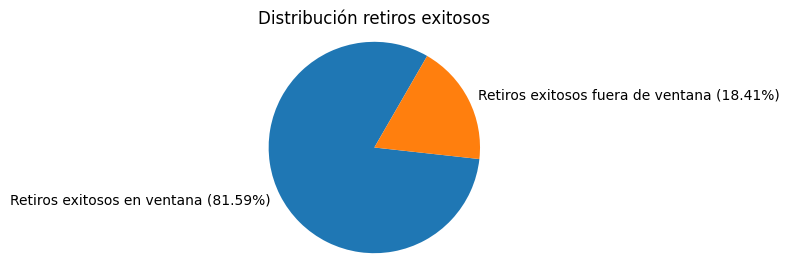

In [281]:
retiros_e = df[df['ultimo_evento_courier']=='Retiro Exitoso']

retiros_exitosos_dentro_ventana = retiros_e[
    (retiros_e['fecha_hora_courier']>=retiros_e['inicio_ventana_retiro']) &
    (retiros_e['fecha_hora_courier']<=retiros_e['fin_ventana_retiro'])]

print(f"Hubieron {len(retiros_exitosos_dentro_ventana)} retiros exitosos dentro de la ventana horaria de un total de {len(retiros_e)} retiros exitosos")

proporcion_retiros_en_ventana = np.around((len(retiros_exitosos_dentro_ventana)/len(retiros_e))*100, 2)
proporcion_retiros_fuera_ventana = np.around(((len(retiros_e)-len(retiros_exitosos_dentro_ventana))/len(retiros_e))*100, 2)

plt.figure(figsize=(3,3))
plt.pie([proporcion_retiros_en_ventana, proporcion_retiros_fuera_ventana], labels=[f'Retiros exitosos en ventana ({proporcion_retiros_en_ventana}%)', f'Retiros exitosos fuera de ventana ({proporcion_retiros_fuera_ventana}%)'], startangle=60)
plt.title('Distribución retiros exitosos')
plt.axis('equal')

plt.show()